In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

# Boostings

Данные с которыми вы будете работать представляют из себя характеристики клиента страховой компании по которым нужно понять будет ли он заинтересован в страховке. Таким образом, страховая компания может более оптимально таргетить рекламу и выстраивать коммуникацию с клиентами, повышая конверсию.

**Описания колонок:**
- Gender - Male, Female
- Age - Возраст
- Driving_License - Наличие водительского удостоверения
- Region_Code - Область проживания
- Previously_Insured - Пользовался ли раньше услугами страховой компании
- Vehicle_Age - Возраст транспортного средства
- Vehicle_Damage - Попадало ли траспортное средство в ДТП
- Annual_Premium - Ежегодные выплаты клиента
- Policy_Sales_Channel - Политика распространения страховых услуг (через посредников, напрямую и т.д.)
- Vintage - Количество дней, в течение которых клиент был связан с компанией 


- **Response** - заинтересован в страховке 1, не откликнулся 0

In [3]:
data = pd.read_csv('vehicle_insurance.csv')

data_copy = data.copy()

**Задание 0.** Проведите небольшой EDA. Посмотрите на распределения некоторых колонок, на матрицу корреляций. Также проверьте баланс классов и посмотрите на распределение возраста транспортного средства в зависимости от response. \
Закодируйте признаки типа `object` с помощью `one-hot` кодирования.

P.S. некоторые не `object`колонки по смыслу очевидно являются категориальными. Так как мы будем строить ансамбли на основе деревьев, их можно оставить в первоначальном виде.

In [4]:
categorical_col = list(data.loc[:, data.dtypes == object].columns)
num_col = [col for col in data.columns if col not in categorical_col]
one_hot = pd.get_dummies(data[categorical_col], prefix=categorical_col, drop_first=True)
data = pd.concat((data.drop(categorical_col, axis=1), one_hot), axis=1)
data.head()



,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,44,1,28.0,0,40454.0,26.0,217,1,1,0,1,1
1,76,1,3.0,0,33536.0,26.0,183,0,1,0,0,0
2,47,1,28.0,0,38294.0,26.0,27,1,1,0,1,1
3,21,1,11.0,1,28619.0,152.0,203,0,1,1,0,0
4,29,1,41.0,1,27496.0,152.0,39,0,0,1,0,0


**Задание 1.** Обучите градиентный бустинг из sklearn на данных и замерьте accuracy и f1-score на тестовой выборке. В качестве параметров ансамбля установите `learning_rate = 1`, `random_state = 1`, `n_estimators = 100`. Изобразите ROC-кривую и посчитайте AUC, оцените качество классификации. (2б)

P.S. для всех прочих моделей в этом домашнем задании тоже фиксируйте `random_state = 1`. Как думаете, что может быть случайного в процедуре обучения градиентного бустинга?

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(learning_rate=1,
                                   random_state=1,
                                   n_estimators=100)
model.fit(X_train, y_train)
print(f'Accuracy на трейне: {model.score(X_train, y_train):.3f}')
print(f'Accuracy на тесте: {model.score(X_test, y_test):.3f}')


Accuracy на трейне: 0.927
Accuracy на тесте: 0.852


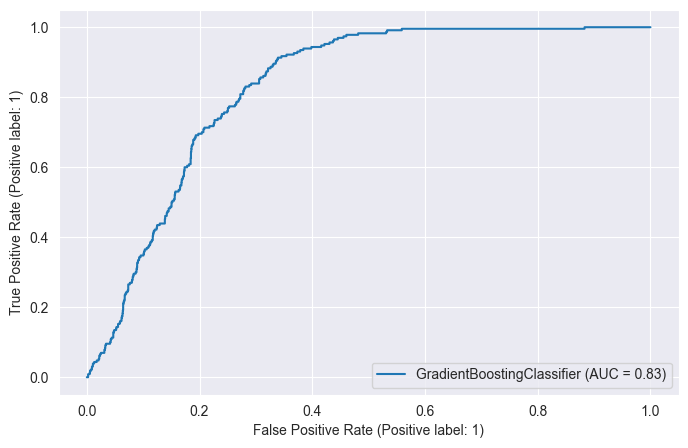

In [67]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_test, y_test)

In [68]:
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
auc(fpr, tpr)

0.828168754605748

**Задание 2.** Переберите параметры `n_estimators` и `learning_rate` по двумерной сетке. При обучении в цикле сразу считайте f1-score на тестовой выборке и сохраняйте результат в матрицу. Для какого алгоритма качество окажется максимальным?

Постройте кривые для метрики f1-score в зависимости от числа шагов для нескольких learning_rate. Изобразите heatmap полученной матрицы. Сделайте вывод, как количество шагов влияет на качество совместно с различной скоростью обучения? (2б)

P.S. для подсчета f1-score передайте в функцию параметр `average='weighted'`, чтобы учитывался еще и баланс классов (вспомните микро/макро-усреднения).

In [69]:
### Задаем сетку параметров

n_estimators_list = [5, 10, 20, 50, 100, 200, 700, 1000]
learning_rate_list = [1, 0.1, 0.01]

In [76]:
f1_score_list = []
for i in learning_rate_list:
    for j in n_estimators_list:
        model = GradientBoostingClassifier(learning_rate=i,
                                   random_state=1,
                                   n_estimators=j)
        model.fit(X_train, y_train)

        f1_score_list.append([i, j, f1_score(y_test, model.predict(X_test), average="weighted")])


In [71]:
f1_score_list_1

[[1, 5, 0.8316268930523463],
 [1, 10, 0.8388422537340711],
 [1, 20, 0.8417751265365147],
 [1, 50, 0.8416015710758443],
 [1, 100, 0.8429263357429234],
 [1, 200, 0.8405304579537709],
 [1, 700, 0.8429880666208791],
 [1, 1000, 0.8412673493239464],
 [0.1, 5, 0.8307588219686919],
 [0.1, 10, 0.8307588219686919],
 [0.1, 20, 0.8307588219686919],
 [0.1, 50, 0.8307588219686919],
 [0.1, 100, 0.8319706786734022],
 [0.1, 200, 0.8354567307692309],
 [0.1, 700, 0.8455443439122964],
 [0.1, 1000, 0.8448147221784212],
 [0.01, 5, 0.8310079575596817],
 [0.01, 10, 0.8310079575596817],
 [0.01, 20, 0.8310079575596817],
 [0.01, 50, 0.8310079575596817],
 [0.01, 100, 0.8307588219686919],
 [0.01, 200, 0.8307588219686919],
 [0.01, 700, 0.8305095541401275],
 [0.01, 1000, 0.8314635220211429]]

<AxesSubplot: >

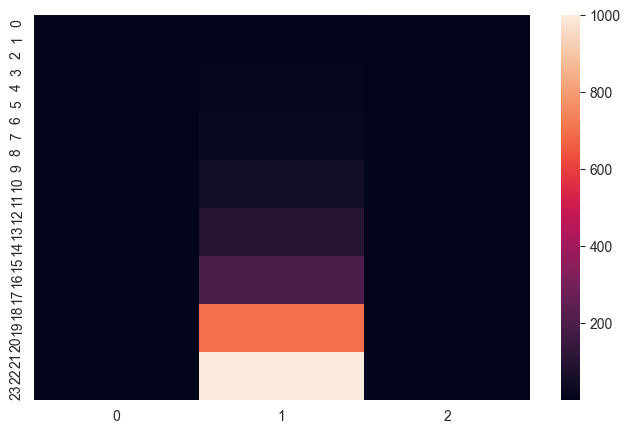

In [19]:
sns.lineplot(x = [step for step in range(len(n_estimators_list))])

**Задание 3.** Вам потребуется обучить 4 модели и посчитать метрику f1-score на тестовой и обучающей выборках для каждой модели. 
1. Случайный лес с максимальной глубиной деревьев 5,
2. Случайный лес с максимальной глубиной деревьев 5000,
3. Градиентный бустинг с максимальной глубиной деревьев 5,
4. Градиентный бустинг с максимальной глубиной деревьев 5000.

Для каждой модели перебирайте значения `n_estimators`, как в предыдущем задании. Отрисуйте графики зависимости f1-score от количества шагов, используя `average='weighted'` для учёта баланса классов. 

Если в качестве базовой модели брать неглубокие деревья, то какая модель лучше запоминает обучающую выборку: случайный лес или градиентный бустинг? Какая из них лучше предсказывает на тестовой выборке? Как изменятся ответы, если базовая модель - это глубокое решающее дерево?

Подвержен ли переобучению случайный лес и градиентный бустинг? Как это отражается на графиках? (4б)

In [13]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]

### Your code is here

**Задание 4.** Установите библиотеку `catboost`. Главной особенностью catboost явялется наличие встроенной обработки категориальных признаков. Для каждого категориального столбца вычисляется следующее значение
$$
avg\_target = \dfrac{countInClass + prior}{totalCount + 1},
$$
* countInClass - количество объектов положительного класса для данной категории **до текущего объекта**,
* prior - некоторая константа для числителя, обычно равна доле положительного класса в таргете,
* totalCount - количество наблюдаемых категорий вплоть **до текущего** с той же категорией, что и у текущего.

Так как первые такие значения будут иметь больший разброс, чем последние, то выборку перемешивают несколько раз и полученные статистики усредняют. 
В отличие от target encoder подсчитанные значения зависят от наблюдаемой истории, т.е. вычисляются только из наблюдений до них, таким образом не происходит target leakage. 

Почитать подробнее можно здесь: [Transforming categorical features](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)

Обучите CatBoostClassifier с дефолтными параметрами. Используйте датасет до  (разбейте на train/test по старой логике с тем же random state'ом). Категориальные колонки передайте в параметр `cat_features` метода `fit`. Catboost сам с ними разберется.

Сравните качество с моделью из предыдущего задания. Стало ли лучше?

Сравните feature importances в модели из задания 2 и в catboost с помощью соответствующих методов, изобразите их, используя `barplot`. \
Какие признаки стали более важными с новым методом кодирования? (4б)

In [46]:
from catboost import CatBoostClassifier

X = data_copy.drop('Response', axis=1)
y = data_copy['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)
model_cat = CatBoostClassifier()
model_cat.fit(X_train, y_train, cat_features=categorical_col)
print(f'Accuracy на трейне: {model_cat.score(X_train, y_train):.3f}')
print(f'Accuracy на тесте: {model_cat.score(X_test, y_test):.3f}')

Learning rate set to 0.025035
0:	learn: 0.6524209	total: 31.5ms	remaining: 31.5s
1:	learn: 0.6213114	total: 60.4ms	remaining: 30.1s
2:	learn: 0.5922961	total: 99.4ms	remaining: 33s
3:	learn: 0.5658834	total: 143ms	remaining: 35.6s
4:	learn: 0.5423457	total: 203ms	remaining: 40.4s
5:	learn: 0.5180857	total: 251ms	remaining: 41.6s
6:	learn: 0.4986798	total: 288ms	remaining: 40.9s
7:	learn: 0.4802832	total: 320ms	remaining: 39.6s
8:	learn: 0.4619128	total: 353ms	remaining: 38.8s
9:	learn: 0.4465202	total: 387ms	remaining: 38.3s
10:	learn: 0.4341692	total: 420ms	remaining: 37.8s
11:	learn: 0.4204912	total: 477ms	remaining: 39.3s
12:	learn: 0.4147382	total: 514ms	remaining: 39s
13:	learn: 0.4094293	total: 547ms	remaining: 38.5s
14:	learn: 0.3996664	total: 580ms	remaining: 38.1s
15:	learn: 0.3902804	total: 613ms	remaining: 37.7s
16:	learn: 0.3851970	total: 648ms	remaining: 37.5s
17:	learn: 0.3768978	total: 685ms	remaining: 37.4s
18:	learn: 0.3694314	total: 719ms	remaining: 37.1s
19:	learn: 0

<AxesSubplot: >

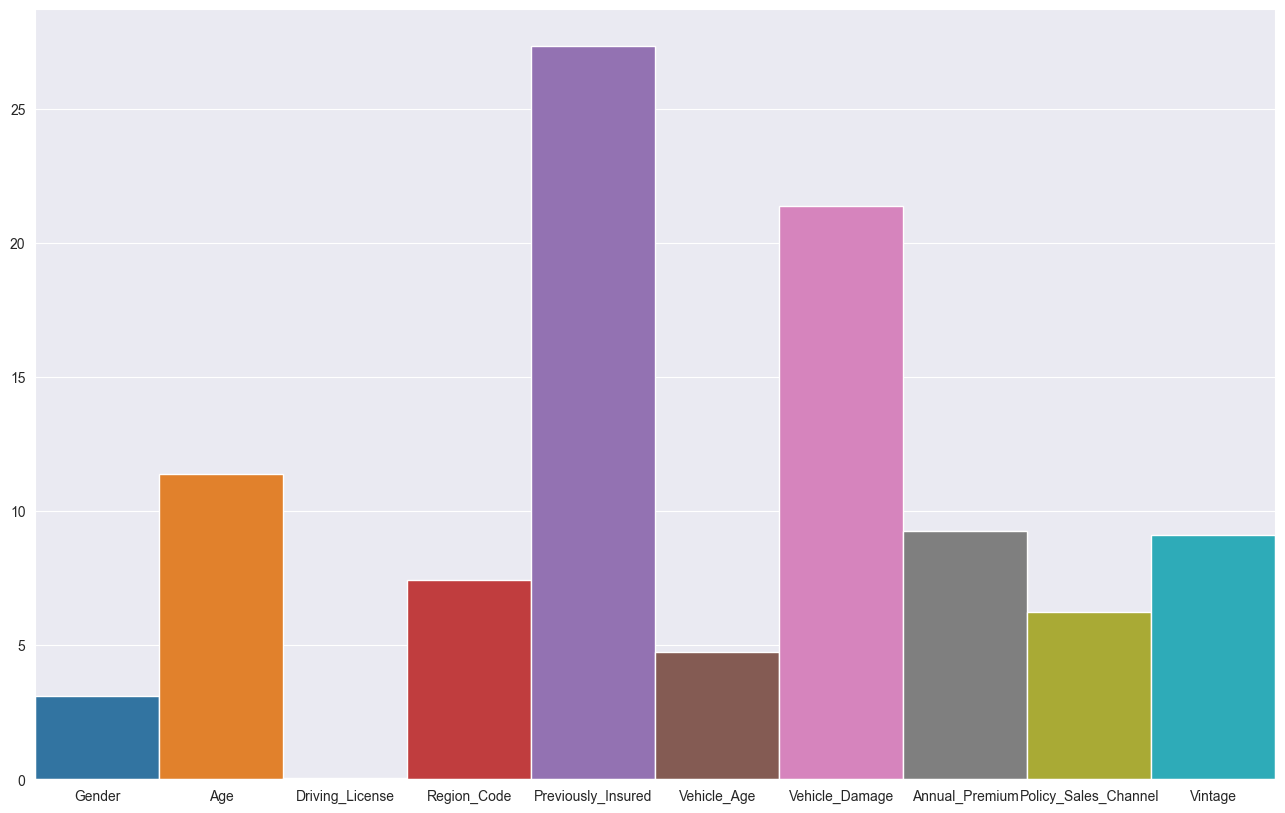

In [64]:
fig = plt.figure()

fig.set_size_inches(16, 10)
sns.barplot(x=X_train.columns, y = model_cat.get_feature_importance(), width=1, capsize=2)

In [57]:
len([i for i in model_cat.get_feature_importance()])

10

In [48]:
data_copy.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [39]:
X_train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
7389,Male,60,1,4.0,0,1-2 Year,Yes,30498.0,124.0,228
9275,Female,23,1,8.0,1,< 1 Year,No,45193.0,152.0,186
2995,Male,74,1,46.0,0,> 2 Years,Yes,2630.0,11.0,231
5316,Female,51,1,28.0,0,1-2 Year,Yes,35828.0,26.0,80
356,Male,22,1,46.0,1,< 1 Year,Yes,28311.0,152.0,240
...,...,...,...,...,...,...,...,...,...,...
9225,Female,24,1,30.0,1,< 1 Year,No,45167.0,152.0,57
4859,Female,46,1,28.0,1,1-2 Year,No,27433.0,124.0,274
3264,Female,40,1,28.0,0,> 2 Years,Yes,44575.0,26.0,88
9845,Male,51,1,16.0,0,1-2 Year,No,24198.0,152.0,81


**Задание 5.** Установите библиотеку `lightgbm`. На сегодняшний день это наиболее быстрый метод градиентного бустинга, при этом расходующий небольшое количество оперативной памяти. Достигает он этого за счет построения деревьев вглубь по листьям (leaf-wise), а не по уровням (level-wise), как другие методы, например XGBoost. 
Более понятно это на картинке:

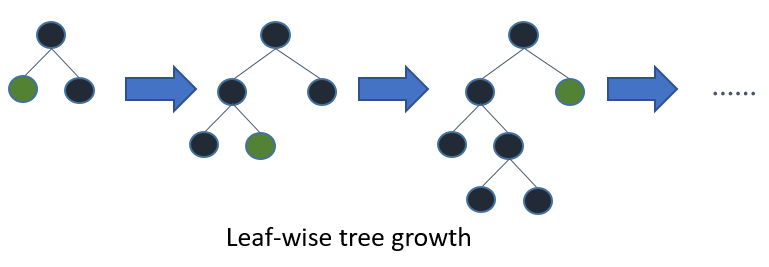

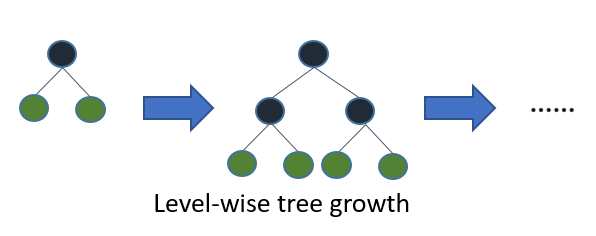

В то время, как XGBoost за раз разделяет вершины на целом уровне той же глубины, LightGBM разделяет одну вершину за раз. Отсюда прирост в скорости.

Обучите `LGBMClassifier` на изначальных(закодированных) данных и добейтесь максимального качества на тестовой выборке, перебрав параметры глубины деревьев, количества шагов, скорости обучения и т.д.

In [44]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [100, 500, 1000, 2000],
          'max_depth': [2, 3, 5, 100],
          'learning_rate': [0.1, 0.01, 0.001]}

model = LGBMClassifier()
search = GridSearchCV(model, params)

search.fit(X_train, y_train)

print(f"Best parameters: {search.best_params_}")
print(classification_report(y_test, search.predict(X_test), digits=3))

Best parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0      0.885     1.000     0.939      1770
           1      0.000     0.000     0.000       230

    accuracy                          0.885      2000
   macro avg      0.443     0.500     0.469      2000
weighted avg      0.783     0.885     0.831      2000

